# Incubadora de Aplicaciones
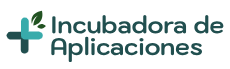

Clusterización de cargas de trabajo en la nube según su estado de salud.

<br>**Integrantes:**
- Federico Ocampo Ortiz - github.com/00Fede
- Edgar Hernando Guerrero Olago - github.com/eguerrer2023
- Daniel Antonio Patiño Fernandez - github.com/ddnny73

# Implementación y validación del modelo

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN
import numpy as np

## apply silhouette score
from sklearn.metrics import silhouette_samples, silhouette_score

# Carga del dataset

In [54]:
# load file
df = pd.read_csv('data/fact_application_v3.csv')
df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
0,-0.313996,0.009662,0.021980,-0.051182,0.038912,0.073440,0.013952,-0.004279,-0.021138
1,-0.186015,-0.084896,-0.077157,-0.022039,-0.138324,0.136892,0.013028,0.001753,-0.049562
2,-0.144646,-0.070178,-0.074369,0.000851,-0.086102,0.114947,0.014596,-0.000334,-0.037148
3,-0.364196,-0.009423,0.018427,-0.078204,-0.025410,0.098116,0.011757,-0.002050,-0.030946
4,0.645316,-0.383417,-0.013289,-0.176348,0.084430,0.290847,-0.042807,-0.002632,-0.080271


# Implementación del modelo

Después de realizar varias pruebas con los metodos disponibles para clusterización, encontramos que el método DBScan puede ser el más adecuado para nuestro caso de estudio, ya que este método no requiere que se especifique el número de clusters, sino que se basa en la densidad de los datos para agruparlos. Además, este método es capaz de detectar outliers, lo cual es muy importante para nuestro caso de estudio, ya que los outliers son los que nos indican que una carga de trabajo está en un estado crítico de salud y requiere atención prioritaria.

Para seleccionar los parámetros del modelo se realizó unas iteración tipo búsqueda en grilla (GridSearch) modificando los valores de los parametros `eps` y `min_samples` 

In [55]:
# apply dbscan
for eps in [0.1, 0.2, 0.3, 0.4]:
    for min_samples in [7, 8, 9, 10, 11, 12]:
        model = DBSCAN(eps=eps, min_samples=min_samples)
        model.fit(df)

        y_dbscan = model.labels_

        df0 = df.copy()
        df0['cluster'] = y_dbscan
        df0 = df0[df0['cluster'] != -1]
        clusters = y_dbscan[y_dbscan != -1]
        avg_score = silhouette_score(df0, clusters)

        n_clusters = len(set(y_dbscan)) - (1 if -1 in y_dbscan else 0)
        n_noise = list(y_dbscan).count(-1)
        print(f"eps: {eps}, min_samples: {min_samples}, clusters: {n_clusters}, noise: {n_noise}, silhouette score: {avg_score:.2%}")

eps: 0.1, min_samples: 7, clusters: 9, noise: 119, silhouette score: 83.19%
eps: 0.1, min_samples: 8, clusters: 7, noise: 140, silhouette score: 83.03%
eps: 0.1, min_samples: 9, clusters: 6, noise: 152, silhouette score: 82.94%
eps: 0.1, min_samples: 10, clusters: 5, noise: 172, silhouette score: 83.09%
eps: 0.1, min_samples: 11, clusters: 5, noise: 175, silhouette score: 84.30%
eps: 0.1, min_samples: 12, clusters: 4, noise: 195, silhouette score: 83.20%
eps: 0.2, min_samples: 7, clusters: 10, noise: 65, silhouette score: 82.36%
eps: 0.2, min_samples: 8, clusters: 10, noise: 65, silhouette score: 82.36%
eps: 0.2, min_samples: 9, clusters: 10, noise: 66, silhouette score: 82.43%
eps: 0.2, min_samples: 10, clusters: 10, noise: 67, silhouette score: 82.46%
eps: 0.2, min_samples: 11, clusters: 9, noise: 77, silhouette score: 82.36%
eps: 0.2, min_samples: 12, clusters: 9, noise: 77, silhouette score: 82.35%
eps: 0.3, min_samples: 7, clusters: 4, noise: 46, silhouette score: 72.40%
eps: 0.3,

Con estos parametros y los resultados de la clusterización de DBScan podemos analizar cual es la mejor combinación de `eps` y `min_samples` para el problema de clusterización dado. El puntaje de silueta mayor dio para `eps` igual a 0.1, sin embargo, la cantidad de ruido es muy alto, y esto puede significar que hayan puntos que no queden en un grupo, aunque si estén cerca de otros puntos. Algo similar ocurre con `eps` igual a 0.2 y diferentes `min_samples`; se generan entre 9 y 10 clusters y esto se aleja de la cantidad de clusters esperados para el contexto del problema. Finalmente se decide trabajar con `eps` igual a 0.3 y `min_samples` igual a 9, que genera un ruido modearodo y tiene un puntaje de silueta óptimo. Escogemos `min_samples` igual a 9 dado que se recomienda para este método de clusters que `min_samples` sea igual o mayor a la cantidad de dimensiones de los datos.

In [56]:
# apply dbscan
model = DBSCAN(eps=0.3, min_samples=9)
model.fit(df)
y_dbscan = model.labels_
n_clusters = len(set(y_dbscan)) - (1 if -1 in y_dbscan else 0)
n_noise = list(y_dbscan).count(-1)
print(f"clusters: {n_clusters}, noise: {n_noise}")

clusters: 4, noise: 46


c:\Users\fede_\anaconda3\envs\py310\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


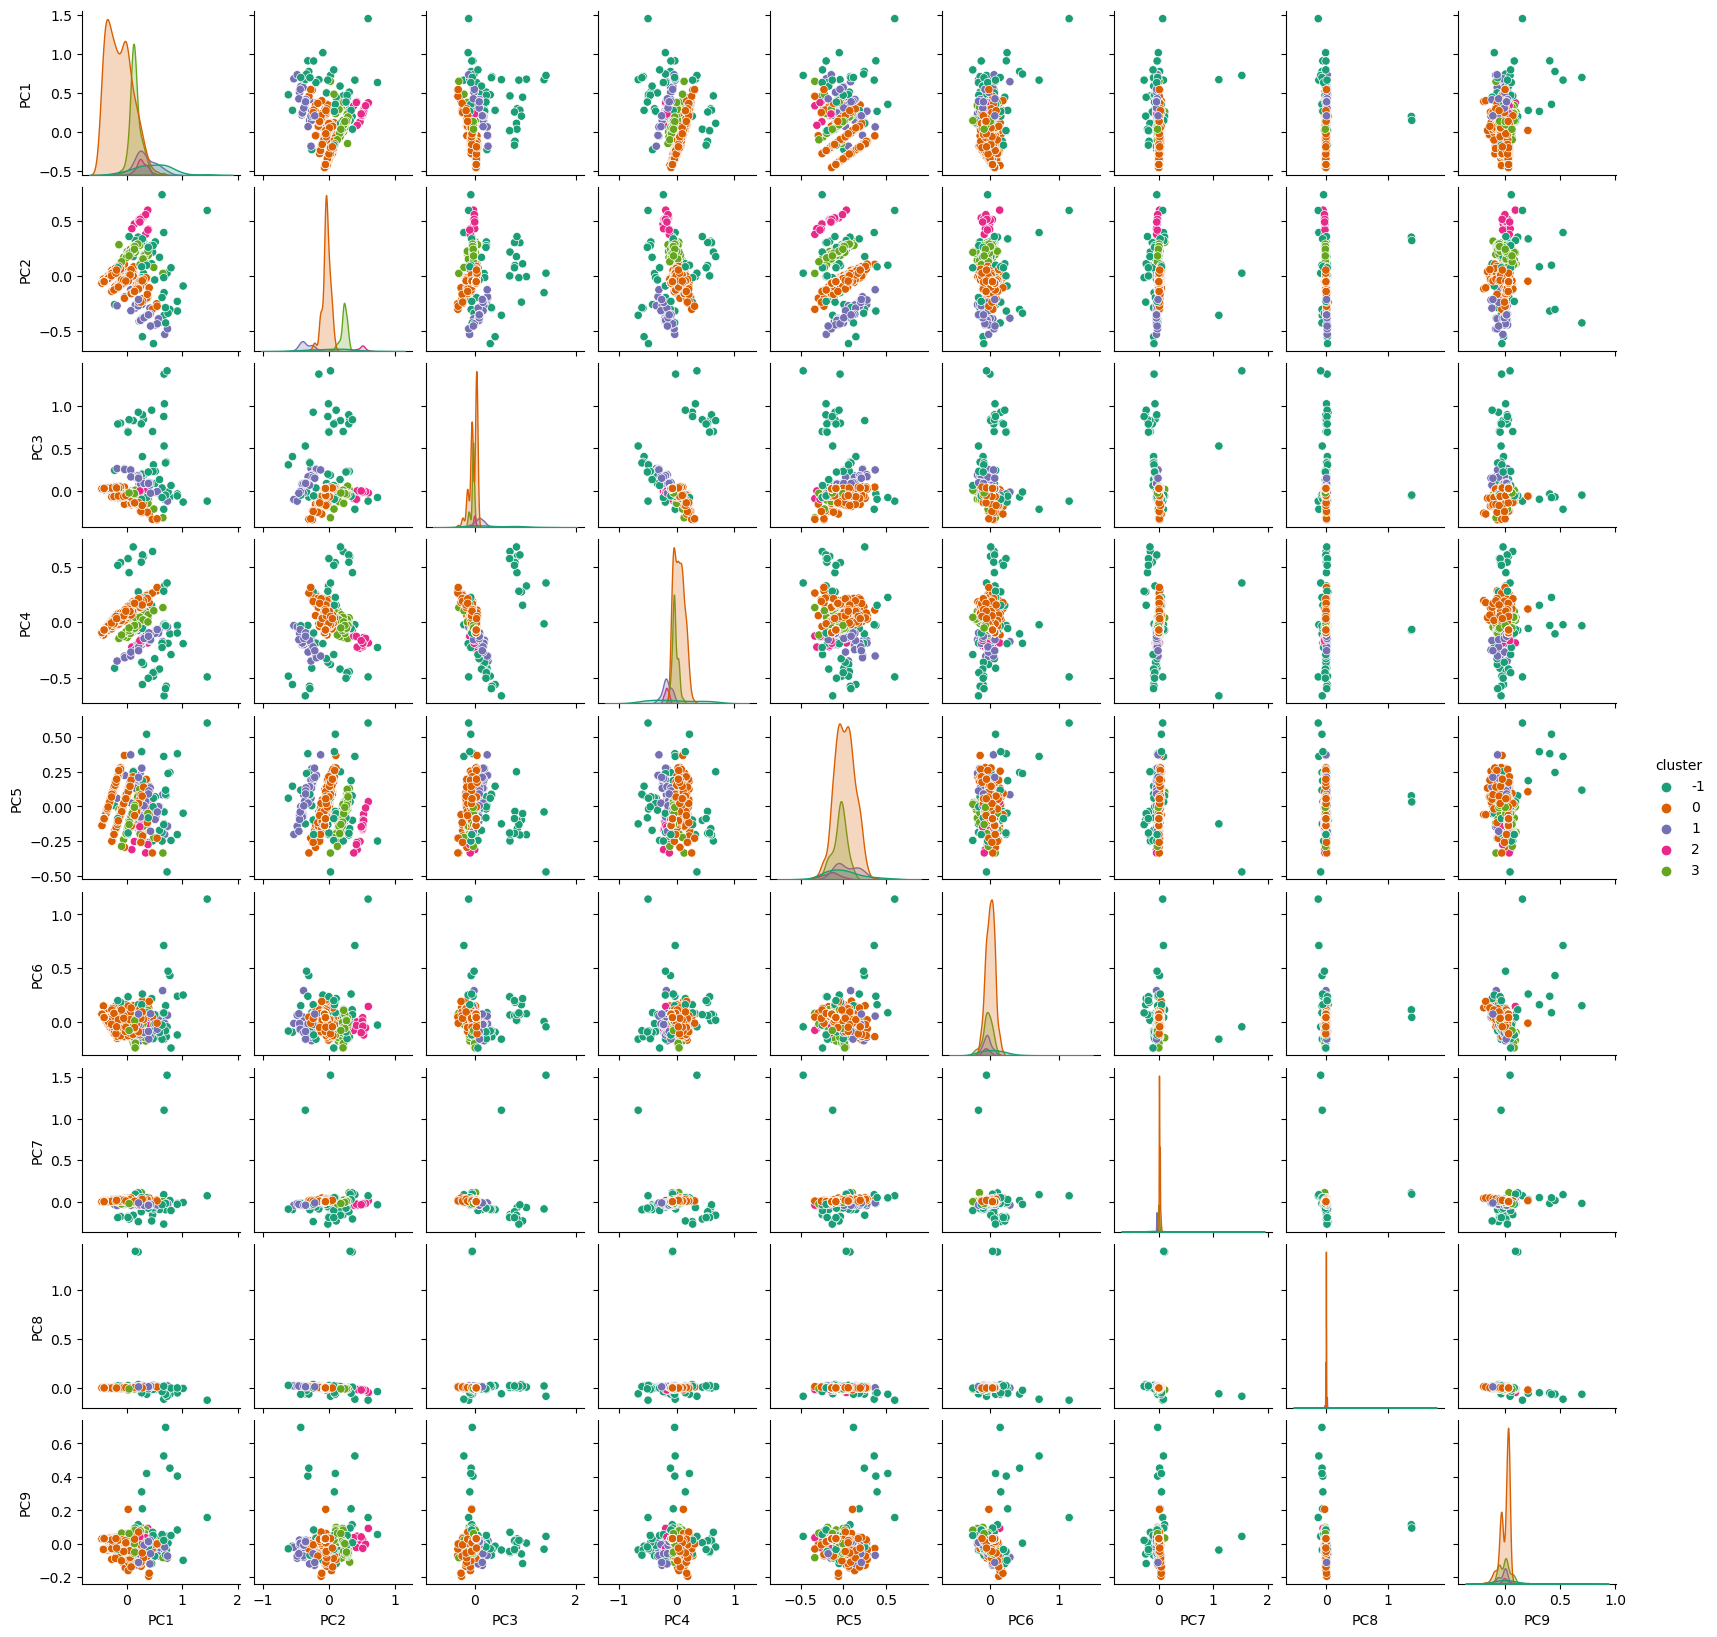

In [57]:
df['cluster'] = y_dbscan
#df0 = df0[df0['cluster'] != -1]

sns.pairplot(df, hue='cluster', palette='Dark2', diag_kind='kde', height=1.85)

El diagrma de dispersión nos muestra que los clusters se forman de manera adecuada. También permite identificar como el método DBScan logra detectar los outliers y agruparlos en un cluster aparte para un posterior procesamiento de estos datos. Puede verse que los grupos estan debidamente separados, lo que es coherente con el score de silueta obtenido de 73%. Si vemos particularmente la relación entre `PC2` y `PC4` puede evidenciarse de mejor manera la separación de los grupos.

<Axes: xlabel='PC2', ylabel='PC4'>

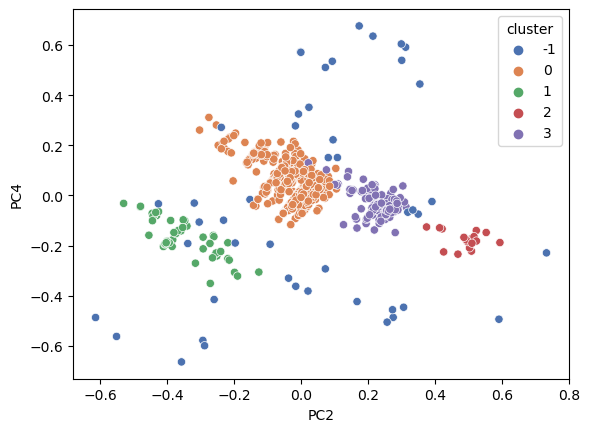

In [58]:
# sns pairplot
sns.scatterplot(data=df, x="PC2", y="PC4", hue="cluster", palette="deep")

In [59]:
df['cluster'].value_counts()

 0    443
 3    124
 1     52
-1     46
 2     17
Name: cluster, dtype: int64

# Metodo de la Silueta

El método de la silueta es una métrica muy utilizada para medir la calidad de una clusterización. Para esto se vale de las medidas de separabilidad intra-cluster, que es la distancia entre los puntos de un mismo cluster, y separabilidad inter-cluster que es la distancia entre puntos de diferentes clusters.

For eps = 0.3, min_samples = 9 the average silhouette_score is : 0.723957566519115


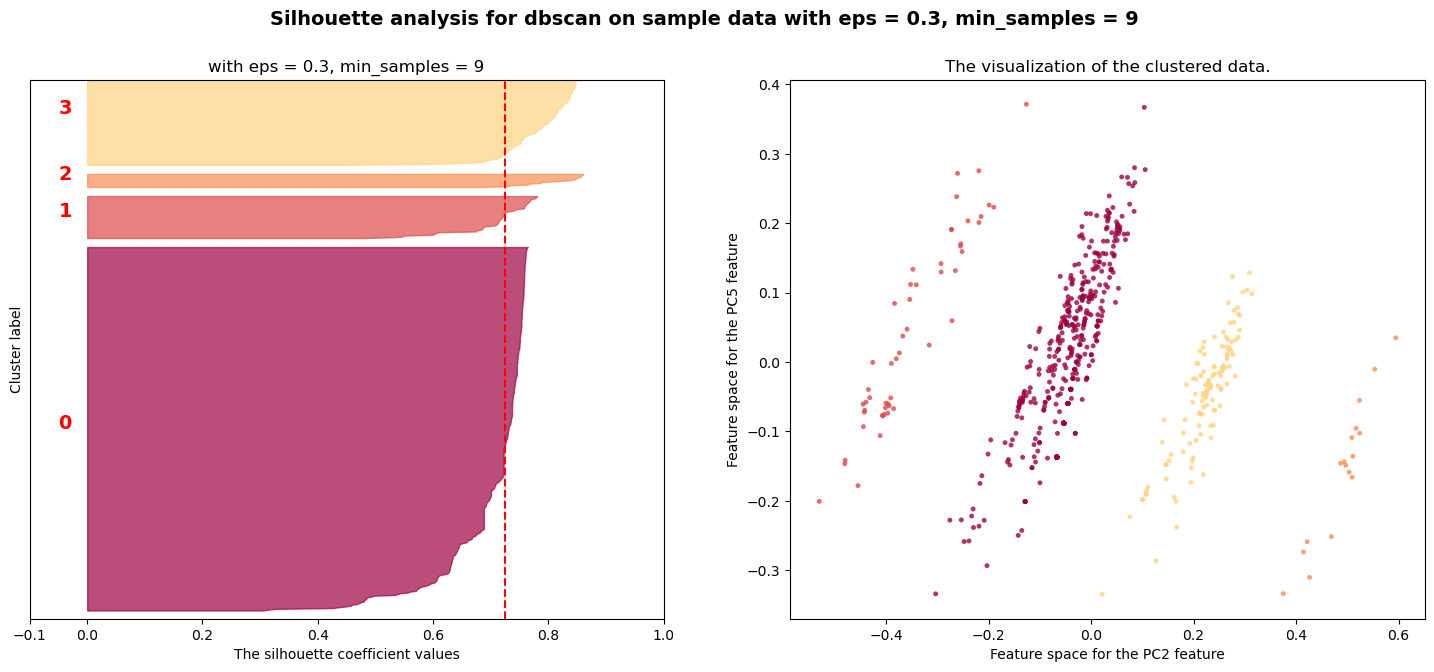

In [11]:
df0 = df[df['cluster'] != -1]
for K in [0.3]:
    for M in range(9,10):
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        ax1.set_xlim([-0.1, 1])
        ax1.set_ylim([0, len(df0) + (K + 1) * 15])

        db = DBSCAN(eps=K, min_samples=M)
        db.fit(df0)
        clusters = db.labels_
        clusters = db.labels_[db.labels_ != -1]

        silhouette_avg = silhouette_score(df0, clusters)
        print(f"For eps = {K}, min_samples = {M} the average silhouette_score is : {silhouette_avg}")

        sample_silhouette_values = silhouette_samples(df0, clusters)

        y_lower = 10
        for i in np.unique( clusters ):
            ith_cluster_silhouette_values = sample_silhouette_values[clusters == i]
            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = plt.colormaps.get_cmap("Spectral")(abs(float(i))*0.5 / len(np.unique( clusters )))
            ax1.fill_betweenx(
                np.arange(y_lower, y_upper),
                0,
                ith_cluster_silhouette_values,
                facecolor=color,
                edgecolor=color,
                alpha=0.7,
                )

            ax1.text(
                -0.05,
                y_lower + 0.5 * size_cluster_i,
                str(i),
                color="red",
                fontweight="bold",
                fontsize=14,
                )

            y_lower = y_upper + 10
        
        
        ax1.set_title(f"with eps = {K}, min_samples = {M}")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        colors = plt.colormaps.get_cmap("Spectral")(abs(clusters.astype(float))*0.5 / len(np.unique( clusters )))
        ax2.scatter(df0['PC2'], df0['PC5'], marker='.', s=50, lw=0, alpha=0.8, c=colors, edgecolor='k')

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the PC2 feature")
        ax2.set_ylabel("Feature space for the PC5 feature")
        
        plt.suptitle(
            (
                f"Silhouette analysis for dbscan on sample data "
                f"with eps = {K}, min_samples = {M}"
            ),
            fontsize=14,
            fontweight="bold",
            )

        # insert
        plt.show()

Un score de 72.4 % en la silueta es un buen resultado. Se puede ver en la gráfica de la izquierda que las siluetas de todos los puntos sobrepasan la silueta media (linea vertical roja). Esto indica que los clusters están bien definidos y que los puntos están más cerca de los puntos de su mismo cluster que de los puntos de otros clusters.

# Interpretabilidad
Para este paso lo primero que se debe hacer es pasar los grupos formados al espacio original de caracteristicas. De este manera es posible ver que caracteristicas son las que mas influyen en la formación de los grupos. 

In [60]:
df0 = pd.read_csv("data/fact_application_full.csv")

# Se tiene el df con todos los campos disponibles --> 912 aplicaciones
# Seleccionamos solo las aplicaciones que tienen recursos en pdn
df_full_pdn = df0[df0['pdnresourcescount'] > 0]

# Eliminamos las características asociadas a los conteos pues solo vamos a usar la característica con el log
features_a_eliminar = ['provider_id', 'snapshot_date_id',  'applicationcode',  'fullresourcescount',
                       'devresourcescount', 'qaresourcescount', 'pdnresourcescount', 'fullaccountscount',
                       'devaccountscount', 'qaaccountscount', 'pdnaccountscount', 'organization_id',
                       'ppn_tm', 'clasification'
                      ]
df_pdn = df_full_pdn.drop(features_a_eliminar, axis=1)


# Eliminamos application_id ya que es un identificador y no una característica que se deba incluir en el análisis
df_pdn = df_pdn.drop('application_id', axis=1)

# También eliminamos las variables de densidad
df_pdn = df_pdn.filter(regex='^(?!.*density).*$')

features = df_pdn.columns.to_list()


In [61]:
# normalicemos nuevamente los datos
minmax = MinMaxScaler()
df_pdn_scaled = minmax.fit_transform(df_pdn)

df_pdn_scaled = pd.DataFrame(df_pdn_scaled, columns=features)

In [62]:
# asignamos el cluster a las observaciones
df_pdn_scaled['cluster'] = y_dbscan

En este diagrama de dispersión solo tenemos en cuenta las variables del pilar de seguridad para poder facilitar la visualización. A primera vista se pueden determinar ciertos grupos que comparten caracteristicas similares. Algunos grupos parecen superpuestos y no muy bien definidos, pero debemos recordar que estos grupos se formaron en un espacio de menor dimensionalidad y al pasarlos al espacio original que tiene más dimensiones, es posible que cambien de forma y se superpongan.

c:\Users\fede_\anaconda3\envs\py310\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


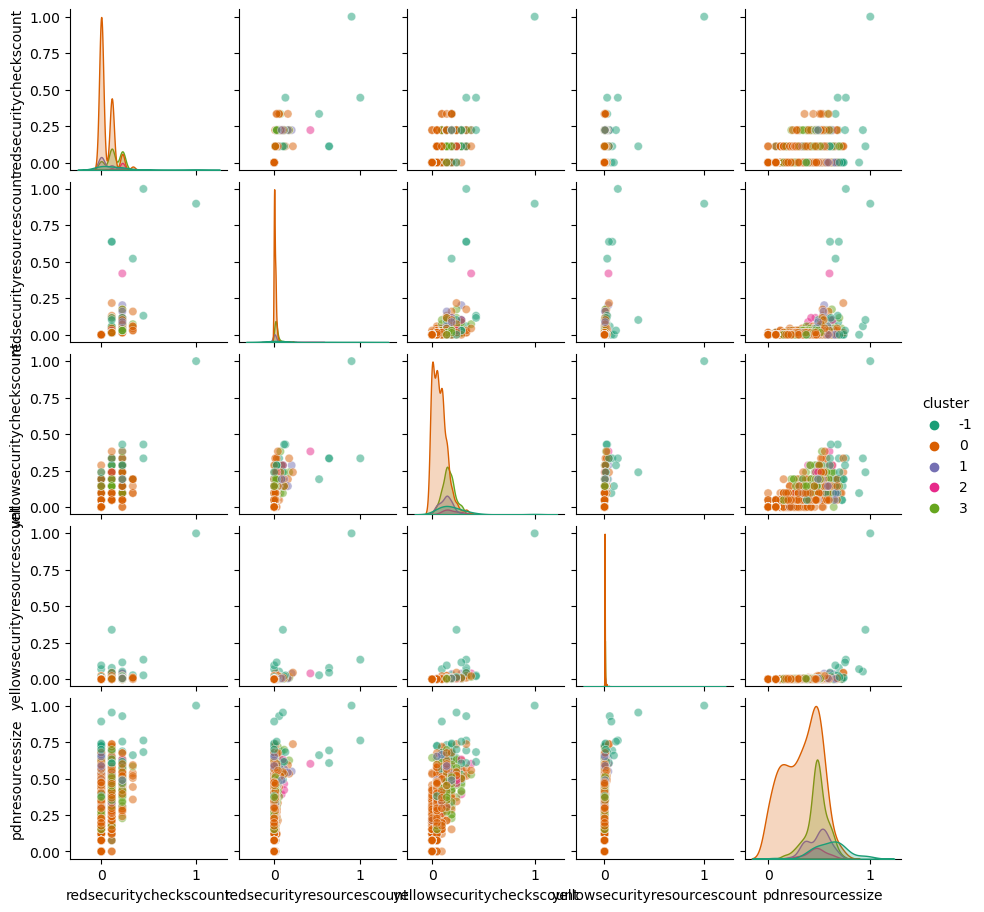

In [63]:
sns.pairplot(df_pdn_scaled.filter(regex="security|cluster|pdnresourcessize", axis=1), hue='cluster', palette='Dark2', diag_kind='kde', height=1.85, plot_kws={'alpha': 0.5})

También es posible realizar un analísis de la media de los clusters para explicar de manera mas clara las caracteristicas de cada grupo.

In [64]:
# medias para cada cluster
df_mean = df_pdn_scaled.groupby('cluster').mean()

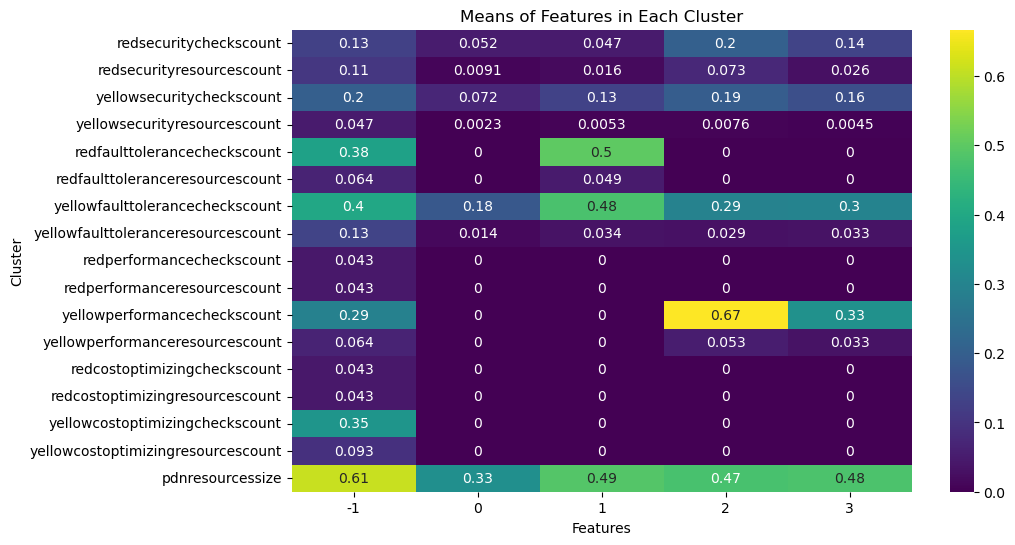

In [65]:
# Create a heatmap to visualize the means of features in each cluster
plt.figure(figsize=(10, 6))
sns.heatmap(df_mean.T, cmap='viridis', annot=True)
plt.xlabel('Features')
plt.ylabel('Cluster')
plt.title('Means of Features in Each Cluster')
plt.show()

Hay similitudes en la media de `pdnresourcessize` para los grupos 1, 2 y 3. Esto indica que los grupos 1, 2 y 3 tienen cargas de trabajo con un tamaño de recursos similares. Algunos grupos también se diferencian en las medias en las variables de checks por pilar. Todos estos datos pueden servir para empezar a entender las características más influyentes de cada grupo y que representan en el contexto del problema.

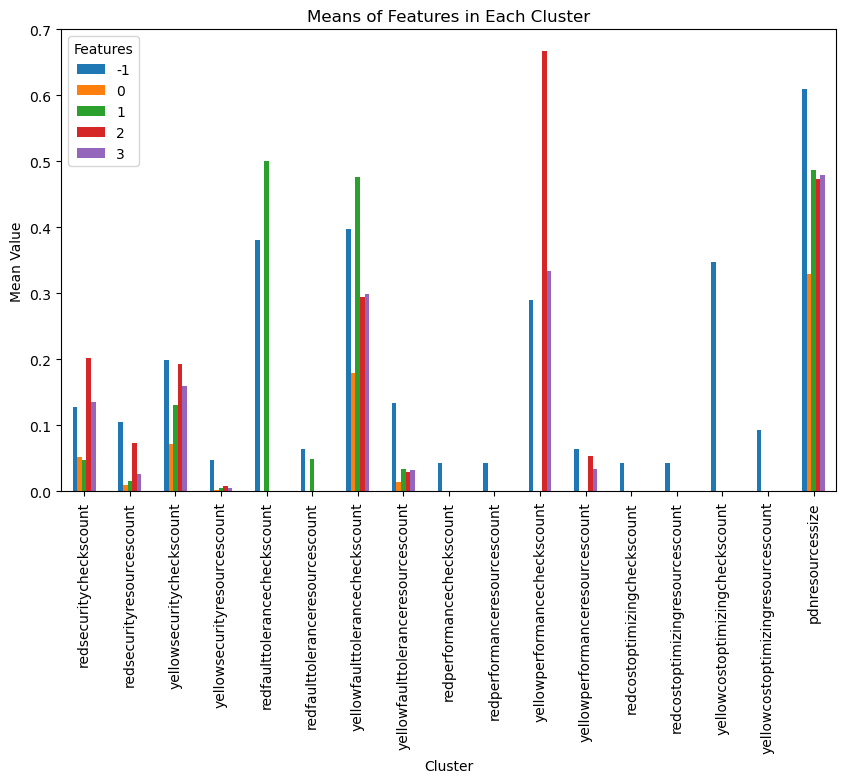

In [27]:
# Plot the means of features for each cluster using a bar chart
df_mean.T.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Cluster')
plt.ylabel('Mean Value')
plt.title('Means of Features in Each Cluster')
plt.legend(title='Features')
plt.show()

Después de analizar las caracteristicas relevantes de cada grupo, podemos generar los siguientes perfiles para las aplicaciones:

- **Grupo 0 - Pequeña con cuidados**: bajo checks de seguridad, tamaño de aplicacion pequeño.
- **Grupo 1 - Con riesgos**: altos flags en tolerancia a fallos, pocos flags de seguridad, tamaño de aplicacion normal
- **Grupo 2 - Requiere atención**: muchos flags de performance, cantidad importante de flags de security, moderada cantidad de flags de tolerancia de fallos, tamaño de aplicacion normal
- **Grupo 3 - Próxima a recibir atención**: flags moderados en performance, moderada cantidad de flags de tolerancia de fallos, cantidad moderada de flags en seguridad, tamaño de aplicacion normal
- **Grupo -1 - Requiere atención personalizada**: Tamaño de aplicación grande, flags de optimización de costos moderado, flags de performance moderado, flags de fault tolerance considerables, flags de seguridad considerables.

In [67]:
df_pdn_scaled.head()

,redsecuritycheckscount,redsecurityresourcescount,yellowsecuritycheckscount,yellowsecurityresourcescount,redfaulttolerancecheckscount,redfaulttoleranceresourcescount,yellowfaulttolerancecheckscount,yellowfaulttoleranceresourcescount,redperformancecheckscount,redperformanceresourcescount,yellowperformancecheckscount,yellowperformanceresourcescount,redcostoptimizingcheckscount,redcostoptimizingresourcescount,yellowcostoptimizingcheckscount,yellowcostoptimizingresourcescount,pdnresourcessize,cluster
0,0.111111,0.043478,0.047619,0.002219,0.0,0.000000,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.212739,0
1,0.111111,0.014493,0.095238,0.000740,0.0,0.000000,0.25,0.009259,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.120091,0
2,0.111111,0.028986,0.095238,0.002959,0.0,0.000000,0.25,0.018519,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.195871,0
3,0.111111,0.014493,0.047619,0.000740,0.0,0.000000,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.120091,0
4,0.222222,0.202899,0.285714,0.038462,0.5,0.717949,0.75,0.009259,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.548590,1


In [68]:
df_pdn_scaled.to_csv('data/clustered_fact_application.csv', index=False)